# SURVIVAL ANALYSIS

**Description:** this notebook executes and explains the survival analysis process for the assignment. The goal for this notebook is to predict the CNCF users survival rate by time.

**Data:** the data loaded was from the Cloud Native Computing Foundation database.

**Team members:** Verónica Gómez, Carlos Grande y Pablo Olmos

**GitHub URL:** https://github.com/charlstown/CNCF_SurvivalAnalysis.git

## INDEX
* [1. Dataframe generation. Analysis and feature selection](#data)
* [2. Feature transformations](#transformation)
* [3. Merging data](#mergeData)
* [4. Event feature, dropout rate](#dropout)
* [5. Survival Analysis](#survival)
---

## Libraries needed

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pandas_profiling as pf
import json
from datetime import datetime
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import numpy as np
from lifelines.plotting import add_at_risk_counts
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Connecting to Elasticsearch

In [2]:
elastic = Elasticsearch(["http://127.0.0.1:9200"])
idx = 'cncf_mapped'
print(elastic)

<Elasticsearch([{'host': '127.0.0.1', 'port': 9200}])>


## Importing scripts
In this section we import the attributes from our python library **elastic_loader** saved on folder "src".

In [3]:
import sys
sys.path.append('../02_src/')
import elastic_query as eq

## 1. Dataframe generation. Analysis and feature selection <a class="anchor" id="data">

### 1.1 Querying the sample to elasticsearch

In [4]:
elastic.indices.put_settings(index= idx,
                        body= {"index" : {
                                "max_result_window" : 20000
                              }})

{'acknowledged': True}

In [5]:
random_sample = {
   "size": 20000,
   "query": {
      "function_score": {
         "functions": [
            {
               "random_score": {
                  "seed": "123"
               }
            }
         ]
      }
   }
}

search = elastic.search(
        index = idx,
        body = random_sample,
        scroll = '2s' # length of time to keep search context
)

In [28]:
git_df = eq.search_to_pandas(search)
git_df.head(5)

,Commit_multi_org_names,Author_gender,demography_min_date,metadata__gelk_backend_name,tz,project,metadata__timestamp,uuid,Author_user_name,cm_title,Commit_id,Commit_user_name,author_date,metadata__enriched_on,Author_domain,tag,author_bot,message_analyzed,author_org_name,hash_short,commit_date,repository_labels,Author_org_name,project_1,Author_uuid,offset,lines_added,utc_commit_date_weekday,author_date_hour,committer_domain,Commit_uuid,commit_date_weekday,branches,committer_name,Commit_gender,Author_gender_acc,author_date_weekday,Commit_org_name,files,metadata__gelk_version,author_id,hash,author_name,author_gender,git_author_domain,utc_author,author_multi_org_names,is_git_commit,origin,utc_author_date_weekday,Author_id,url_id,title,github_repo,lines_changed,utc_commit_date_hour,demography_max_date,author_user_name,grimoire_creation_date,author_gender_acc,Commit_bot,Commit_gender_acc,Commit_domain,author_domain,repo_name,lines_removed,git_uuid,utc_commit,commit_date_hour,Author_multi_org_names,metadata__filter_raw,Author_bot,message,author_uuid,time_to_commit_hours,utc_author_date_hour,Author_name,Commit_name,metadata__updated_on,commit_tags
0,[Unknown],Unknown,2019-02-18T09:46:03.000Z,GitEnrich,2,Graduated,2019-08-02T13:41:59.997215+00:00,85db904f3b8f9af614631021405f00569a22bad2,,Graduated,a95dc0f69626e9fe30cff300fcb1d6be5d379fd5,,2019-04-02T09:32:00,2019-10-07T17:35:12.185625+00:00,gmx.ch,https://github.com/kubernetes/test-infra.git,False,Update knative/build and knative/pkg Go module...,Unknown,72faaa,2019-04-02T09:32:00,[],Unknown,Graduated,a95dc0f69626e9fe30cff300fcb1d6be5d379fd5,None,6,2,9,gmx.ch,a95dc0f69626e9fe30cff300fcb1d6be5d379fd5,2,[],Cosmin Cojocar,Unknown,0,2,Unknown,2,0.62.0,a95dc0f69626e9fe30cff300fcb1d6be5d379fd5,72faaabd5ef32f949d6dfd820e758521d3374bcc,Cosmin Cojocar,Unknown,gmx.ch,2019-04-02T07:32:00,[Unknown],1,https://github.com/kubernetes/test-infra.git,2,a95dc0f69626e9fe30cff300fcb1d6be5d379fd5,kubernetes/test-infra/commit/72faaabd5ef32f949...,Update knative/build and knative/pkg Go module...,kubernetes/test-infra,12,7,2019-06-11T08:04:31.000Z,,2019-04-02T09:32:00+02:00,0,False,0,gmx.ch,gmx.ch,https://github.com/kubernetes/test-infra.git,6,85db904f3b8f9af614631021405f00569a22bad2,2019-04-02T07:32:00,9,[Unknown],None,False,Update knative/build and knative/pkg Go module...,a95dc0f69626e9fe30cff300fcb1d6be5d379fd5,0.00,7,Cosmin Cojocar,Cosmin Cojocar,2019-04-02T07:32:00+00:00,NaN
1,[Unknown],Unknown,2017-05-05T14:26:28.000Z,GitEnrich,-5,Graduated,2020-01-31T20:56:46.323923+00:00,ab60524c4279f5605df3ff9d3fc1f5a0d8376b65,,Graduated,c9c46b0eccf0771d77ec8d94571a2d6b0b8a7987,,2019-12-15T18:29:27,2020-01-31T21:16:41.970272+00:00,gmail.com,https://github.com/kubernetes/kubectl.git,False,Extend --dry-run to support string values.\n\n...,Unknown,c0b11f,2019-12-15T18:29:27,[],Unknown,Graduated,c054542f1433129c279043f633ab9bb5b544db4a,None,95,7,18,users.noreply.github.com,c9c46b0eccf0771d77ec8d94571a2d6b0b8a7987,7,[],Kubernetes Publisher,Unknown,0,7,Unknown,22,0.67.0,c054542f1433129c279043f633ab9bb5b544db4a,c0b11fa131d0cb2d63c833af6e4b7e46ffe80788,Julian V. Modesto,Unknown,gmail.com,2019-12-15T23:29:27,[Unknown],1,https://github.com/kubernetes/kubectl.git,7,c054542f1433129c279043f633ab9bb5b544db4a,kubernetes/kubectl/commit/c0b11fa131d0cb2d63c8...,Extend --dry-run to support string values.,kubernetes/kubectl,122,23,2020-04-02T21:14:17.000Z,,2019-12-15T18:29:27-05:00,0,True,0,users.noreply.github.com,gmail.com,https://github.com/kubernetes/kubectl.git,27,ab60524c4279f5605df3ff9d3fc1f5a0d8376b65,2019-12-15T23:29:27,18,[Unknown],None,False,Extend --dry-run to support string values.\n\n...,c054542f1433129c279043f633ab9bb5b544db4a,0.00,23,Julian V. Modesto,Kubernetes Publisher,2019-12-15T23:29:27+00:00,NaN
2,NaN,Unknown,2017-02-01T06:01:34.000Z,GitEnrich,-4,Graduated,2019-08-02T13:37:44.985805+00:00,067ac31634ab959b9ed4179bb9aad9238eac72f1,Unknown,Graduated,e512d4ceda58ef6045aeba3dd21ff53f22156ae6,Unknown,2017-07-20T22:07:20

### 1.2 Dataframe cleanning

In [29]:
columns = git_df.columns
columns

Index(['Commit_multi_org_names', 'Author_gender', 'demography_min_date',
       'metadata__gelk_backend_name', 'tz', 'project', 'metadata__timestamp',
       'uuid', 'Author_user_name', 'cm_title', 'Commit_id', 'Commit_user_name',
       'author_date', 'metadata__enriched_on', 'Author_domain', 'tag',
       'author_bot', 'message_analyzed', 'author_org_name', 'hash_short',
       'commit_date', 'repository_labels', 'Author_org_name', 'project_1',
       'Author_uuid', 'offset', 'lines_added', 'utc_commit_date_weekday',
       'author_date_hour', 'committer_domain', 'Commit_uuid',
       'commit_date_weekday', 'branches', 'committer_name', 'Commit_gender',
       'Author_gender_acc', 'author_date_weekday', 'Commit_org_name', 'files',
       'metadata__gelk_version', 'author_id', 'hash', 'author_name',
       'author_gender', 'git_author_domain', 'utc_author',
       'author_multi_org_names', 'is_git_commit', 'origin',
       'utc_author_date_weekday', 'Author_id', 'url_id', 'title',
   

### 1.3 Variables filtering

In [31]:
final=git_df[[
'author_id','hash','author_bot', 'author_date', 'author_date_weekday','author_date_hour','author_domain','author_name',
'author_org_name','commit_date','commit_date_weekday','commit_date_hour','committer_domain','committer_name',
'demography_max_date', 'demography_min_date', 'files','github_repo','grimoire_creation_date','lines_added',
'lines_changed','lines_removed','message_analyzed','metadata__gelk_version','metadata__timestamp','metadata__updated_on',
'origin','project','repo_name','tag','title','tz','utc_author','utc_commit']]

In [35]:
final.to_pickle("../01_data/survival_df.pkl")

In [33]:
final = pd.read_pickle("final.pkl")

In [10]:
#Con una muestra nada mas
prof = pf.ProfileReport(final) 
prof.to_file(output_file='final_salida.html')

### 1.4 Dropping bots column

In [11]:
final = final.drop(final[final.author_bot ==True].index)

In [12]:
final['author_bot'].value_counts()

False    428105
Name: author_bot, dtype: int64

## 2. Feature transformations <a class="anchor" id="transformation">

In [13]:
pruebas = final[['author_id','hash', 'lines_added', 'files', 'lines_changed','lines_removed','project','author_date_weekday','commit_date_hour',
                'committer_domain','author_org_name']]

### 2.1 New features
The aim is to create de week feature to calculate the difference between commits on weekends or during the week.

In [14]:
pruebas['week'] = np.where(pruebas['author_date_weekday']<6, 'Semana', 'Finde')

In [15]:
pruebas['horario']  = np.where(pruebas['commit_date_hour']<16, 'manana', 'tarde')

In [16]:
pruebas['committer_domain'] .value_counts()

google.com                                  111831
github.com                                   96928
gmail.com                                    67109
users.noreply.github.com                     35697
redhat.com                                   18422
                                             ...  
ok.dk                                            1
kailashs-macbookair.roam.corp.google.com         1
inuus.com                                        1
dimas.dev                                        1
                                                 1
Name: committer_domain, Length: 2814, dtype: int64

### 2.2 Gropping data

In [17]:
col         = 'committer_domain'
conditions  = [ pruebas['committer_domain'] =='google.com',
                pruebas['committer_domain'] =='github.com', 
                pruebas['committer_domain'] =='gmail.com', 
                pruebas['committer_domain'] =='users.noreply.github.com',
                pruebas['committer_domain'] =='redhat.com'
               ]
choices     = [ "C_google.com", 'C_github.com', 'C_gmail.com' ,'C_users.noreply','C_redhat.com']
pruebas['dominio']  = np.select(conditions, choices, default='C_Resto')

In [18]:
pruebas['dominio'] .value_counts()

C_google.com       111831
C_Resto             98118
C_github.com        96928
C_gmail.com         67109
C_users.noreply     35697
C_redhat.com        18422
Name: dominio, dtype: int64

In [19]:
pruebas['author_org_name'] .value_counts()

Unknown           302173
Google, Inc.       55995
Red Hat            32234
CoreOS, Inc.        6714
Docker, Inc.        5275
                   ...  
Thesys CAT LLC         1
Duke.edu               1
Parallels              1
Bluescape              1
lightbend              1
Name: author_org_name, Length: 160, dtype: int64

In [20]:
col         = 'author_org_name'
conditions  = [ pruebas['author_org_name'] =='Unknown',
                pruebas['author_org_name'] =='Google, Inc.', 
                pruebas['author_org_name'] =='Red Hat', 
                pruebas['author_org_name'] =='CoreOS, Inc.',
                pruebas['author_org_name'] =='Docker, Inc.'
               ]
choices     = [ "A_Unknown", 'A_Google, Inc.', 'A_Red Hat' ,'A_CoreOS, Inc.','A_Docker, Inc.']
pruebas['organzacion']  = np.select(conditions, choices, default='A_Resto')

In [21]:
pruebas['organzacion'] .value_counts()

A_Unknown         302173
A_Google, Inc.     55995
A_Red Hat          32234
A_Resto            25714
A_CoreOS, Inc.      6714
A_Docker, Inc.      5275
Name: organzacion, dtype: int64

### 2.3 From categorical to dummy

In [22]:
dummy =pd.get_dummies(pruebas['project'])
dummy2=pd.get_dummies(pruebas['week'])
dummy3=pd.get_dummies(pruebas['horario'])
dummy4=pd.get_dummies(pruebas['dominio'])
dummy5=pd.get_dummies(pruebas['organzacion'])
#dummy5=pd.get_dummies(pruebas['a_dominio'])
#dummy6=pd.get_dummies(pruebas['repo'])

pruebas=pd.concat([pruebas,dummy],axis=1)
pruebas=pd.concat([pruebas,dummy2],axis=1)
pruebas=pd.concat([pruebas,dummy3],axis=1)
pruebas=pd.concat([pruebas,dummy4],axis=1)
pruebas=pd.concat([pruebas,dummy5],axis=1)
#pruebas=pd.concat([pruebas,dummy6],axis=1)

pruebas.head(5)

,author_id,hash,lines_added,files,lines_changed,lines_removed,project,author_date_weekday,commit_date_hour,committer_domain,author_org_name,week,horario,dominio,organzacion,Graduated,Incubating,Finde,Semana,manana,tarde,C_Resto,C_github.com,C_gmail.com,C_google.com,C_redhat.com,C_users.noreply,"A_CoreOS, Inc.","A_Docker, Inc.","A_Google, Inc.",A_Red Hat,A_Resto,A_Unknown
zero,183f4592bb7b37d6053a6a9ce9980c599c766ba2,f948bf81368eb13afc7270e4ad9fd9a4126c6ff2,21,1,28,7,Graduated,5,10,loadsmart.com,Unknown,Semana,manana,C_Resto,A_Unknown,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1
one,c04049bcd92d96bcfb399a80c9197c63dbc82728,860c7d0a42cc09a6cea2abef77d479b005828142,1,1,1,0,Graduated,1,8,github.com,Unknown,Semana,manana,C_github.com,A_Unknown,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1
2,c04049bcd92d96bcfb399a80c9197c63dbc82728,9105932510e05c8ce7666bdc15d952d11cb323db,1,1,1,0,Graduated,2,9,heptio.com,Unknown,Semana,manana,C_Resto,A_Unknown,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1
3,c04049bcd92d96bcfb399a80c9197c63dbc82728,12722567fe7ef27611762e5bd611068735f7b68d,15,1,30,15,Graduated,2,12,users.noreply.github.com,Unknown,Semana,manana,C_users.noreply,A_Unknown,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1
4,c04049bcd92d96bcfb399a80c9197c63dbc82728,9f901b1cf83b42aeec1c4118b7c7c2395eb56077,2,1,4,2,Graduated,7,18,github.com,Unknown,Finde,tarde,C_github.com,A_Unknown,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1


In [23]:
sum_dummy=pruebas.groupby('author_id').agg({'lines_added':'sum',  
                                  'lines_changed':'sum',  
                                  'lines_removed':'sum',  
                                  'Graduated':'sum', 
                                  'Incubating':'sum',
                                  'Semana':'sum', 
                                  'Finde':'sum',  
                                  'manana':'sum', 
                                  'tarde':'sum', 
                                  'hash':'count',
                                  'C_google.com':'sum', 
                                  'C_github.com':'sum',
                                  'C_gmail.com':'sum',
                                  'C_users.noreply':'sum',
                                  'C_redhat.com':'sum',  
                                  'C_Resto':'sum',
                                  "A_Unknown":'sum',
                                  'A_Google, Inc.':'sum',
                                  'A_Red Hat':'sum',
                                  'A_CoreOS, Inc.':'sum',
                                  'A_Docker, Inc.':'sum',
                                  'A_Resto':'sum',
                                  'files':'sum'})

In [24]:
sum_dummy.head(5)

,lines_added,lines_changed,lines_removed,Graduated,Incubating,Semana,Finde,manana,tarde,hash,C_google.com,C_github.com,C_gmail.com,C_users.noreply,C_redhat.com,C_Resto,A_Unknown,"A_Google, Inc.",A_Red Hat,"A_CoreOS, Inc.","A_Docker, Inc.",A_Resto,files
author_id,,,,,,,,,,,,,,,,,,,,,,,
00011aab835817d41311b6201e9bdb3376db6725,323,567,244,0.0,8.0,8.0,0.0,3.0,5.0,8,8.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,10
000238c004624ab2a2c73992562111e9a566b083,1324,2728,1404,16.0,0.0,12.0,4.0,12.0,4.0,16,0.0,0.0,0.0,10.0,0.0,6.0,16.0,0.0,0.0,0.0,0.0,0.0,36
00024380e0d8d854b42bf505333f245de77bd71d,4873,6527,1654,54.0,0.0,52.0,2.0,38.0,16.0,54,0.0,0.0,0.0,6.0,0.0,48.0,54.0,0.0,0.0,0.0,0.0,0.0,109
000540ad087cd6a4b8c5cbfcccfe7a0ebc574fbe,66,80,14,4.0,0.0,2.0,2.0,2.0,2.0,4,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,6
0009a37bda192abde71638d500d46c057e238636,16,18,2,1.0,0.0,1.0,0.0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1


### 2.4 Dates differences, age rate in Github and recency between commits
We create the variable **recency** to calculate th days between commits.

In [25]:
fechas= final[['author_id', 'author_date']]

In [26]:
fechas['dia'] = fechas['author_date'].str[:10]
fechas['dia'] = pd.to_datetime(fechas['dia'])

In [27]:
fechas = fechas.sort_values(by=['author_id','dia'])
fechas['Recencia'] = fechas.groupby('author_id')['dia'].diff().apply(lambda x: x.days)
fechas['Recencia'].fillna(0, inplace=True)

In [28]:
fechas.head(5)

,author_id,author_date,dia,Recencia
294366,00011aab835817d41311b6201e9bdb3376db6725,2016-09-22T16:58:16,2016-09-22,0.0
482390,00011aab835817d41311b6201e9bdb3376db6725,2016-09-23T11:12:52,2016-09-23,1.0
95073,00011aab835817d41311b6201e9bdb3376db6725,2017-08-17T17:09:56,2017-08-17,328.0
482389,00011aab835817d41311b6201e9bdb3376db6725,2017-10-03T17:30:04,2017-10-03,47.0
482388,00011aab835817d41311b6201e9bdb3376db6725,2017-10-09T17:09:41,2017-10-09,6.0


### 2.5 Gropping byy author and frecuency

In [29]:
recencia=fechas.groupby('author_id').agg({'Recencia':'mean'})

In [30]:
recencia.head(5)

,Recencia
author_id,
00011aab835817d41311b6201e9bdb3376db6725,48.250000
000238c004624ab2a2c73992562111e9a566b083,2.250000
00024380e0d8d854b42bf505333f245de77bd71d,5.055556
000540ad087cd6a4b8c5cbfcccfe7a0ebc574fbe,0.500000
0009a37bda192abde71638d500d46c057e238636,0.000000


### 2.6 Final age variables creation

In [31]:
fechas2= final[['author_id', 'demography_max_date','demography_min_date']]

In [32]:
fechas2['inicio'] = fechas2['demography_min_date'].str[:10]
fechas2['final']  = fechas2['demography_max_date'].str[:10]
fechas2['inicio'] = pd.to_datetime(fechas2['inicio'])
fechas2['final']  = pd.to_datetime(fechas2['final'])
fechas2['antiguedad']=(fechas2['final']-fechas2['inicio'] ).apply(lambda x: x.days)

In [33]:
fechas2.head(5)

,author_id,demography_max_date,demography_min_date,inicio,final,antiguedad
zero,183f4592bb7b37d6053a6a9ce9980c599c766ba2,2018-12-28T12:44:34.000Z,2018-12-28T11:53:52.000Z,2018-12-28,2018-12-28,0.0
one,c04049bcd92d96bcfb399a80c9197c63dbc82728,2019-05-22T07:45:51.000Z,2017-08-14T08:13:15.000Z,2017-08-14,2019-05-22,646.0
2,c04049bcd92d96bcfb399a80c9197c63dbc82728,2019-05-22T07:45:51.000Z,2017-08-14T08:13:15.000Z,2017-08-14,2019-05-22,646.0
3,c04049bcd92d96bcfb399a80c9197c63dbc82728,2019-05-22T07:45:51.000Z,2017-08-14T08:13:15.000Z,2017-08-14,2019-05-22,646.0
4,c04049bcd92d96bcfb399a80c9197c63dbc82728,2019-05-22T07:45:51.000Z,2017-08-14T08:13:15.000Z,2017-08-14,2019-05-22,646.0


In [34]:
antiguedad=fechas2.groupby('author_id').agg({'antiguedad':'last'})

In [35]:
antiguedad.head(5)

,antiguedad
author_id,
00011aab835817d41311b6201e9bdb3376db6725,386.0
000238c004624ab2a2c73992562111e9a566b083,305.0
00024380e0d8d854b42bf505333f245de77bd71d,1186.0
000540ad087cd6a4b8c5cbfcccfe7a0ebc574fbe,2.0
0009a37bda192abde71638d500d46c057e238636,0.0


## 3. Merging data <a class="anchor" id="mergeData">

In [36]:
analisis=pd.concat([recencia,antiguedad],axis=1)
analisis=pd.concat([analisis,sum_dummy],axis=1)

In [37]:
analisis['lines_for_hash']                 =analisis['lines_added']/analisis['hash']
analisis['lines_changed_for_hash']         =analisis['lines_changed']/analisis['hash']
analisis['lines_removed_for_hash']         =analisis['lines_removed']/analisis['hash']
analisis['files_for_hash']                 =analisis['files']/analisis['hash']
analisis['percent_graduated']              =analisis['Graduated']/analisis['hash']
analisis['percent_Incubating']             =analisis['Incubating']/analisis['hash']
analisis['percent_Semana']                 =analisis['Semana']/analisis['hash']
analisis['percent_Finde']                  =analisis['Finde']/analisis['hash']                                                             
analisis['percent_manana']                 =analisis['manana']/analisis['hash']
analisis['percent_tarde']                  =analisis['tarde']/analisis['hash']  
analisis['percent_Committer_google.com']   =analisis['C_google.com']/analisis['hash']  
analisis['percent_Committer_github.com']   =analisis['C_github.com']/analisis['hash']  
analisis['percent_Committer_gmail.com']    =analisis['C_gmail.com']/analisis['hash']  
analisis['percent_Committer_users.noreply']=analisis['C_users.noreply']/analisis['hash']
analisis['percent_Committer_redhat.com']   =analisis['C_redhat.com']/analisis['hash']
analisis['percent_Committer_resto']        =analisis['C_Resto']/analisis['hash']
analisis['percent_Autor_Unknown']          =analisis["A_Unknown"]/analisis['hash']  
analisis['percent_Autor_Google']           =analisis['A_Google, Inc.']/analisis['hash']  
analisis['percent_Autor_Red Hat']          =analisis['A_Red Hat']/analisis['hash']  
analisis['percent_Autor_CoreOS']           =analisis['A_CoreOS, Inc.']/analisis['hash']  
analisis['percent_Autor_Docker']           =analisis['A_Docker, Inc.']/analisis['hash']  
analisis['percent_Autor_Resto']            =analisis['A_Resto']/analisis['hash']  
analisis.head(5)

,Recencia,antiguedad,lines_added,lines_changed,lines_removed,Graduated,Incubating,Semana,Finde,manana,tarde,hash,C_google.com,C_github.com,C_gmail.com,C_users.noreply,C_redhat.com,C_Resto,A_Unknown,"A_Google, Inc.",A_Red Hat,"A_CoreOS, Inc.","A_Docker, Inc.",A_Resto,files,lines_for_hash,lines_changed_for_hash,lines_removed_for_hash,files_for_hash,percent_graduated,percent_Incubating,percent_Semana,percent_Finde,percent_manana,percent_tarde,percent_Committer_google.com,percent_Committer_github.com,percent_Committer_gmail.com,percent_Committer_users.noreply,percent_Committer_redhat.com,percent_Committer_resto,percent_Autor_Unknown,percent_Autor_Google,percent_Autor_Red Hat,percent_Autor_CoreOS,percent_Autor_Docker,percent_Autor_Resto
author_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00011aab835817d41311b6201e9bdb3376db6725,48.250000,386.0,323,567,244,0.0,8.0,8.0,0.0,3.0,5.0,8,8.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,10,40.375000,70.87500,30.50000,1.250000,0.0,1.0,1.000000,0.000000,0.375000,0.625000,1.0,0.0,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0
000238c004624ab2a2c73992562111e9a566b083,2.250000,305.0,1324,2728,1404,16.0,0.0,12.0,4.0,12.0,4.0,16,0.0,0.0,0.0,10.0,0.0,6.0,16.0,0.0,0.0,0.0,0.0,0.0,36,82.750000,170.50000,87.75000,2.250000,1.0,0.0,0.750000,0.250000,0.750000,0.250000,0.0,0.0,0.0,0.625000,0.0,0.375000,1.0,0.0,0.0,0.0,0.0,0.0
00024380e0d8d854b42bf505333f245de77bd71d,5.055556,1186.0,4873,6527,1654,54.0,0.0,52.0,2.0,38.0,16.0,54,0.0,0.0,0.0,6.0,0.0,48.0,54.0,0.0,0.0,0.0,0.0,0.0,109,90.240741,120.87037,30.62963,2.018519,1.0,0.0,0.962963,0.037037,0.703704,0.296296,0.0,0.0,0.0,0.111111,0.0,0.888889,1.0,0.0,0.0,0.0,0.0,0.0
000540ad087cd6a4b8c5cbfcccfe7a0ebc574fbe,0.500000,2.0,66,80,14,4.0,0.0,2.0,2.0,2.0,2.0,4,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,6,16.500000,20.00000,3.50000,1.500000,1.0,0.0,0.500000,0.500000,0.500000,0.500000,0.0,0.0,0.0,1.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0
0009a37bda192abde71638d500d46c057e238636,0.000000,0.0,16,18,2,1.0,0.0,1.0,0.0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,16.000000,18.00000,2.00000,1.000000,1.0,0.0,1.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0


In [38]:
df_suvirval=analisis [['antiguedad', 'Recencia', 'files','hash',
       'lines_for_hash', 'lines_changed_for_hash', 'lines_removed_for_hash',
       'files_for_hash', 'percent_graduated', 'percent_Incubating',
       'percent_Semana', 'percent_Finde', 'percent_manana', 'percent_tarde',
       'percent_Committer_google.com', 'percent_Committer_github.com',
       'percent_Committer_gmail.com', 'percent_Committer_users.noreply',
       'percent_Committer_redhat.com', 'percent_Committer_resto',
       'percent_Autor_Unknown', 'percent_Autor_Google',
       'percent_Autor_Red Hat', 'percent_Autor_CoreOS', 'percent_Autor_Docker',
       'percent_Autor_Resto' ,'lines_added', 'lines_changed','lines_removed',
        'Graduated','Incubating','Semana' , 'Finde','manana','tarde','C_google.com']]

df_suvirval2=analisis [['antiguedad', 'Recencia', 'files','hash',
'lines_added','lines_changed','lines_removed','Graduated','Incubating','Semana','Finde' ,                                                   
'manana','tarde','C_google.com','C_github.com' , 'C_gmail.com','C_users.noreply','C_redhat.com',
'C_Resto',"A_Unknown",'A_Google, Inc.','A_Red Hat' ,'A_CoreOS, Inc.','A_Docker, Inc.','A_Resto'                                  ]]

In [39]:
df_suvirval.head(5)

,antiguedad,Recencia,files,hash,lines_for_hash,lines_changed_for_hash,lines_removed_for_hash,files_for_hash,percent_graduated,percent_Incubating,percent_Semana,percent_Finde,percent_manana,percent_tarde,percent_Committer_google.com,percent_Committer_github.com,percent_Committer_gmail.com,percent_Committer_users.noreply,percent_Committer_redhat.com,percent_Committer_resto,percent_Autor_Unknown,percent_Autor_Google,percent_Autor_Red Hat,percent_Autor_CoreOS,percent_Autor_Docker,percent_Autor_Resto,lines_added,lines_changed,lines_removed,Graduated,Incubating,Semana,Finde,manana,tarde,C_google.com
author_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00011aab835817d41311b6201e9bdb3376db6725,386.0,48.250000,10,8,40.375000,70.87500,30.50000,1.250000,0.0,1.0,1.000000,0.000000,0.375000,0.625000,1.0,0.0,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,323,567,244,0.0,8.0,8.0,0.0,3.0,5.0,8.0
000238c004624ab2a2c73992562111e9a566b083,305.0,2.250000,36,16,82.750000,170.50000,87.75000,2.250000,1.0,0.0,0.750000,0.250000,0.750000,0.250000,0.0,0.0,0.0,0.625000,0.0,0.375000,1.0,0.0,0.0,0.0,0.0,0.0,1324,2728,1404,16.0,0.0,12.0,4.0,12.0,4.0,0.0
00024380e0d8d854b42bf505333f245de77bd71d,1186.0,5.055556,109,54,90.240741,120.87037,30.62963,2.018519,1.0,0.0,0.962963,0.037037,0.703704,0.296296,0.0,0.0,0.0,0.111111,0.0,0.888889,1.0,0.0,0.0,0.0,0.0,0.0,4873,6527,1654,54.0,0.0,52.0,2.0,38.0,16.0,0.0
000540ad087cd6a4b8c5cbfcccfe7a0ebc574fbe,2.0,0.500000,6,4,16.500000,20.00000,3.50000,1.500000,1.0,0.0,0.500000,0.500000,0.500000,0.500000,0.0,0.0,0.0,1.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,66,80,14,4.0,0.0,2.0,2.0,2.0,2.0,0.0
0009a37bda192abde71638d500d46c057e238636,0.0,0.000000,1,1,16.000000,18.00000,2.00000,1.000000,1.0,0.0,1.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,16,18,2,1.0,0.0,1.0,0.0,1.0,0.0,0.0


## 4. Event feature, dropout rate <a class="anchor" id="dropout">

Time elapsed from the last user commit to the last maximum commit date. May 2020.

In [40]:
evento=final[['author_id', 'author_date','demography_max_date']]

In [41]:
max(evento['author_date'])
evento['final']  = evento['demography_max_date'].str[:10]
evento['max']    = max(evento['author_date'].str[:10])
evento['final']  = pd.to_datetime(evento['final'])
evento['max']    = pd.to_datetime(evento['max'])

In [42]:
evento['SurvivalTime']=(evento['max'] -evento['final']).apply(lambda x: x.days)

In [43]:
evento=evento [['author_id','SurvivalTime']]
evento=evento.groupby('author_id').agg({'SurvivalTime':'last'})

In [44]:
evento.head(5)

,SurvivalTime
author_id,
00011aab835817d41311b6201e9bdb3376db6725,946.0
000238c004624ab2a2c73992562111e9a566b083,183.0
00024380e0d8d854b42bf505333f245de77bd71d,30.0
000540ad087cd6a4b8c5cbfcccfe7a0ebc574fbe,886.0
0009a37bda192abde71638d500d46c057e238636,568.0


### 4.1 Event definition
Let's study the distribution to consider the binary variable event.

In [45]:
evento['SurvivalTime'].quantile([.1, .25, .5, .75,.90,.95,.99]) 

0.10      51.0
0.25     220.0
0.50     571.0
0.75    1016.0
0.90    1443.0
0.95    1719.0
0.99    2167.0
Name: SurvivalTime, dtype: float64

In [46]:
evento['SurvivalTime'].mean()

672.528208829544

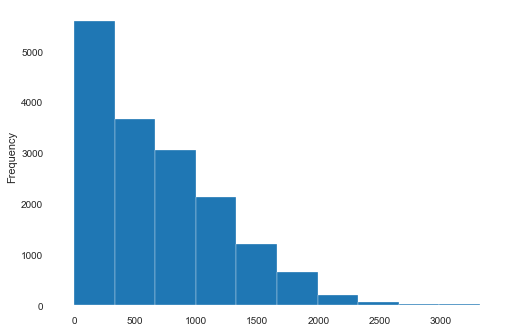

In [47]:
evento.SurvivalTime.plot.hist()

### 4.2 Dead users by inactivity
Let's check if a user is innactive by a 365 days limit with no commits.

In [48]:
evento['evento']    = np.where(evento['SurvivalTime']>6, 1, 0)

In [49]:
evento['evento'].value_counts()

1    16179
0      456
Name: evento, dtype: int64

### 4.3 Final dataframe ready for the survival analysis

In [50]:
df_suvirval2=pd.concat([df_suvirval,evento],axis=1)

In [51]:
df_suvirval2.head(5)

,antiguedad,Recencia,files,hash,lines_for_hash,lines_changed_for_hash,lines_removed_for_hash,files_for_hash,percent_graduated,percent_Incubating,percent_Semana,percent_Finde,percent_manana,percent_tarde,percent_Committer_google.com,percent_Committer_github.com,percent_Committer_gmail.com,percent_Committer_users.noreply,percent_Committer_redhat.com,percent_Committer_resto,percent_Autor_Unknown,percent_Autor_Google,percent_Autor_Red Hat,percent_Autor_CoreOS,percent_Autor_Docker,percent_Autor_Resto,lines_added,lines_changed,lines_removed,Graduated,Incubating,Semana,Finde,manana,tarde,C_google.com,SurvivalTime,evento
author_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00011aab835817d41311b6201e9bdb3376db6725,386.0,48.250000,10,8,40.375000,70.87500,30.50000,1.250000,0.0,1.0,1.000000,0.000000,0.375000,0.625000,1.0,0.0,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,323,567,244,0.0,8.0,8.0,0.0,3.0,5.0,8.0,946.0,1
000238c004624ab2a2c73992562111e9a566b083,305.0,2.250000,36,16,82.750000,170.50000,87.75000,2.250000,1.0,0.0,0.750000,0.250000,0.750000,0.250000,0.0,0.0,0.0,0.625000,0.0,0.375000,1.0,0.0,0.0,0.0,0.0,0.0,1324,2728,1404,16.0,0.0,12.0,4.0,12.0,4.0,0.0,183.0,1
00024380e0d8d854b42bf505333f245de77bd71d,1186.0,5.055556,109,54,90.240741,120.87037,30.62963,2.018519,1.0,0.0,0.962963,0.037037,0.703704,0.296296,0.0,0.0,0.0,0.111111,0.0,0.888889,1.0,0.0,0.0,0.0,0.0,0.0,4873,6527,1654,54.0,0.0,52.0,2.0,38.0,16.0,0.0,30.0,1
000540ad087cd6a4b8c5cbfcccfe7a0ebc574fbe,2.0,0.500000,6,4,16.500000,20.00000,3.50000,1.500000,1.0,0.0,0.500000,0.500000,0.500000,0.500000,0.0,0.0,0.0,1.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,66,80,14,4.0,0.0,2.0,2.0,2.0,2.0,0.0,886.0,1
0009a37bda192abde71638d500d46c057e238636,0.0,0.000000,1,1,16.000000,18.00000,2.00000,1.000000,1.0,0.0,1.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,16,18,2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,568.0,1


### 4.4 Saving the dataframe

In [ ]:
df_suvirval_t.to_pickle("../01_data/df_suvirval_t.pkl")

#### Descrictivo de las Variables del DF

###### 'evento': 0/1 definición interna abandona GitHub si no sube commits en 365 días
###### 'antiguedad': Número de días entre el primer y útimo commit del Autor
###### 'Recencia'  : Número de días medio entre los commits del Autor   
###### 'files'     : Número de Files tratados por el Autor
###### 'hash'      : Número de Hash por autor
###### 'lines_for_hash' : Número de Lineas mediosubidas por Hash 
###### 'lines_changed_for_hash' : Número de Lineas medio cambiadas por Hash 
###### 'lines_removed_for_hash' : Número de Lineas medio eliminadas por Hash 
###### 'files_for_hash'         : Número medio de files for hash 
###### 'percent_graduated'      : % de los hash graduated
###### 'percent_Incubating'     : % de los hash incubating NO la incluímos
###### 'percent_Semana'         : % de los commits subidos entre semana
###### 'percent_Finde'          : % de los commits subidos los fines de semana NO la incluímos
###### 'percent_manana'         : % de los commits subidos en horiario de mañana
###### 'percent_tarde'          : % de los commits subidos en horiario de tarde NO la incluímos
###### 'percent_Committer_google.com' : % de los commits del dominio del Commiter es google.com
###### 'percent_Committer_github.com' : % de los commits del dominio del Commiter es github.com
###### 'percent_Committer_gmail.com' : % de los commits del dominio del Commiter es gmail.com
###### 'percent_Committer_users.noreply': % de los commits del dominio del Commiter es users.noreply
###### 'percent_Committer_redhat.com': % de los commits del dominio del Commiter es redhat.com
###### 'percent_Committer_resto': % de los commits del dominio del Commiter es el Resto
###### 'percent_Autor_Unknown' : % de los commits del dominio del Autor es Unknown
###### 'percent_Autor_Google': % de los commits del dominio del Autor es Unknown
###### 'percent_Autor_Red Hat': % de los commits del dominio del Autor es Red Hat
###### 'percent_Autor_CoreOS' : % de los commits del dominio del Autor es CoreOS
###### 'percent_Autor_Docker': % de los commits del dominio del Autor es Docker
###### 'percent_Autor_Resto' : % de los commits del dominio del Autor es Resto

In [52]:
df_suvirval2 = df_suvirval2.dropna()

In [53]:
df_suvirval2.head(5)

,antiguedad,Recencia,files,hash,lines_for_hash,lines_changed_for_hash,lines_removed_for_hash,files_for_hash,percent_graduated,percent_Incubating,percent_Semana,percent_Finde,percent_manana,percent_tarde,percent_Committer_google.com,percent_Committer_github.com,percent_Committer_gmail.com,percent_Committer_users.noreply,percent_Committer_redhat.com,percent_Committer_resto,percent_Autor_Unknown,percent_Autor_Google,percent_Autor_Red Hat,percent_Autor_CoreOS,percent_Autor_Docker,percent_Autor_Resto,lines_added,lines_changed,lines_removed,Graduated,Incubating,Semana,Finde,manana,tarde,C_google.com,SurvivalTime,evento
author_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00011aab835817d41311b6201e9bdb3376db6725,386.0,48.250000,10,8,40.375000,70.87500,30.50000,1.250000,0.0,1.0,1.000000,0.000000,0.375000,0.625000,1.0,0.0,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,323,567,244,0.0,8.0,8.0,0.0,3.0,5.0,8.0,946.0,1
000238c004624ab2a2c73992562111e9a566b083,305.0,2.250000,36,16,82.750000,170.50000,87.75000,2.250000,1.0,0.0,0.750000,0.250000,0.750000,0.250000,0.0,0.0,0.0,0.625000,0.0,0.375000,1.0,0.0,0.0,0.0,0.0,0.0,1324,2728,1404,16.0,0.0,12.0,4.0,12.0,4.0,0.0,183.0,1
00024380e0d8d854b42bf505333f245de77bd71d,1186.0,5.055556,109,54,90.240741,120.87037,30.62963,2.018519,1.0,0.0,0.962963,0.037037,0.703704,0.296296,0.0,0.0,0.0,0.111111,0.0,0.888889,1.0,0.0,0.0,0.0,0.0,0.0,4873,6527,1654,54.0,0.0,52.0,2.0,38.0,16.0,0.0,30.0,1
000540ad087cd6a4b8c5cbfcccfe7a0ebc574fbe,2.0,0.500000,6,4,16.500000,20.00000,3.50000,1.500000,1.0,0.0,0.500000,0.500000,0.500000,0.500000,0.0,0.0,0.0,1.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,66,80,14,4.0,0.0,2.0,2.0,2.0,2.0,0.0,886.0,1
0009a37bda192abde71638d500d46c057e238636,0.0,0.000000,1,1,16.000000,18.00000,2.00000,1.000000,1.0,0.0,1.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,16,18,2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,568.0,1


#Analisis descriptivo de nuestra BBDD
prof = pf.ProfileReport(df_suvirval2) 
prof.to_file(output_file='df_suvirval2.html')

## 5. Survival Analysis <a class="anchor" id="survival">

Survival analysis is a branch of statistics for analyzing the expected duration of time until one or more events happen, such as death in biological organisms and failure in mechanical systems. This topic is called reliability theory or reliability analysis in engineering, duration analysis or duration modelling in economics, and event history analysis in sociology. 

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_suvirval2, df_suvirval2['evento'], test_size=0.2, random_state=737)

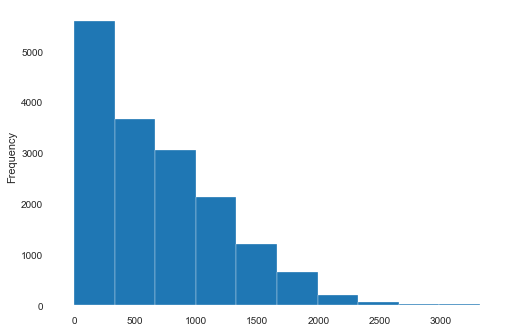

In [55]:
df_suvirval2.SurvivalTime.plot.hist()

In [64]:
df_suvirval2['anyo']=df_suvirval2['SurvivalTime']/365.25
# making boolean series for a team name 
elderly = df_suvirval2['anyo']<1
df_suvirval3=df_suvirval2[elderly]

### 5.1 Kaplan-Meier estimator

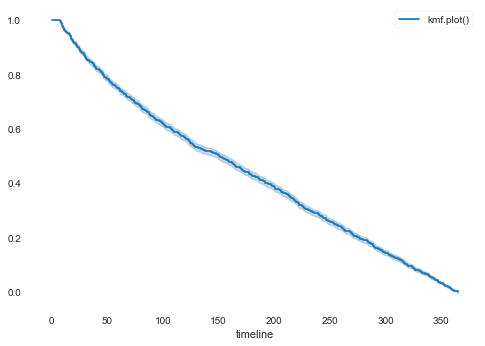

In [65]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(df_suvirval3['SurvivalTime'], df_suvirval3['evento'], label="kmf.plot()")
kmf.plot()

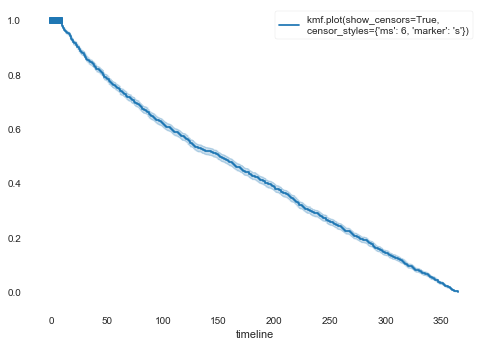

In [66]:
kmf.fit(df_suvirval3['SurvivalTime'], df_suvirval3['evento'], label="kmf.plot(show_censors=True, \ncensor_styles={'ms': 6, 'marker': 's'})")
kmf.plot(show_censors=True, censor_styles={'ms': 6, 'marker': 's'})

#### multiple at-risk counts below plots

In [67]:
def kmg (var):   
    df_suvirval3['ant']=pd.qcut(df_suvirval3[var], 2, labels=["low", "high"],duplicates='drop')
    ix = df_suvirval3['ant'] == 'high'
    ax = plt.subplot(111)
    kmf_control = KaplanMeierFitter()
    ax = kmf_control.fit(df_suvirval3.loc[ix]['SurvivalTime'], df_suvirval3.loc[ix]['evento'], label=var+'_high').plot(ax=ax)
    kmf_exp = KaplanMeierFitter()
    ax = kmf_exp.fit(df_suvirval3.loc[~ix]['SurvivalTime'], df_suvirval3.loc[~ix]['evento'], label=var+'_low').plot(ax=ax)
    return add_at_risk_counts(kmf_exp, kmf_control, ax=ax)

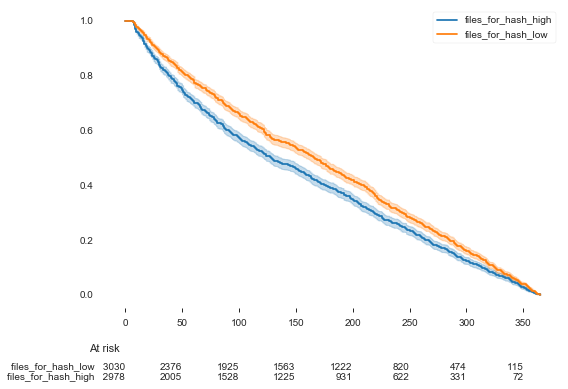

In [68]:
kmg('files_for_hash')

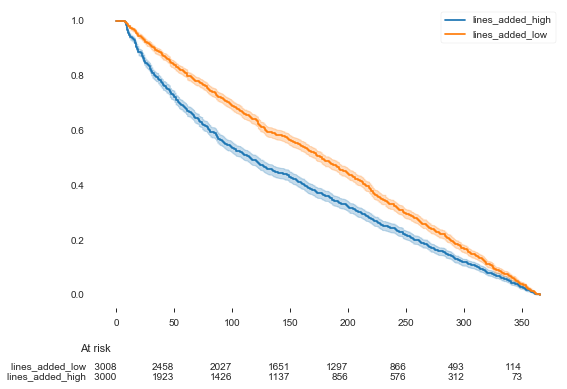

In [69]:
kmg('lines_added')

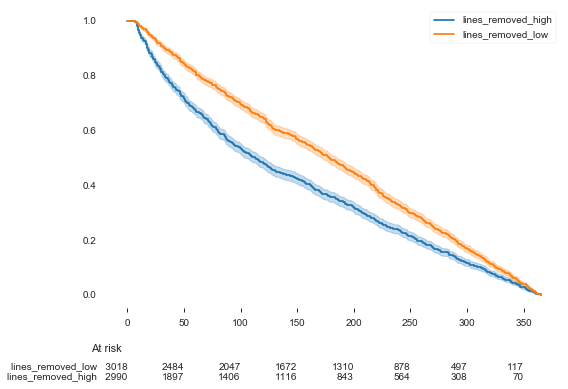

In [79]:
kmg('lines_removed')

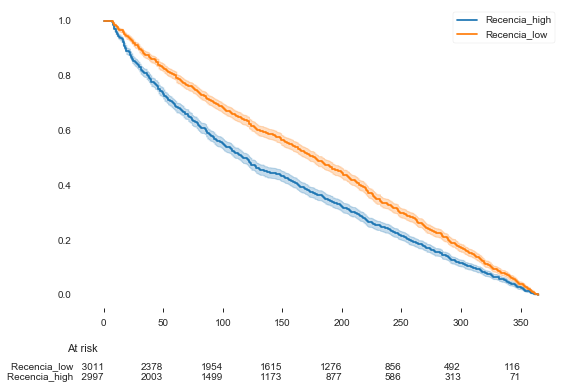

In [78]:
kmg('Recencia')

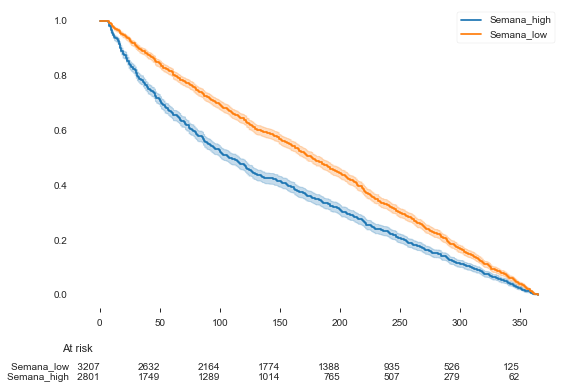

In [80]:
kmg('Semana')

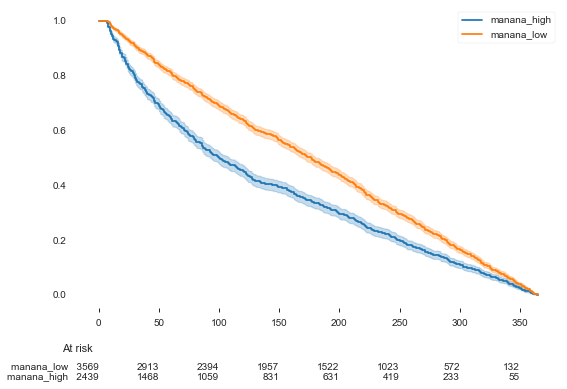

In [81]:
kmg('manana')

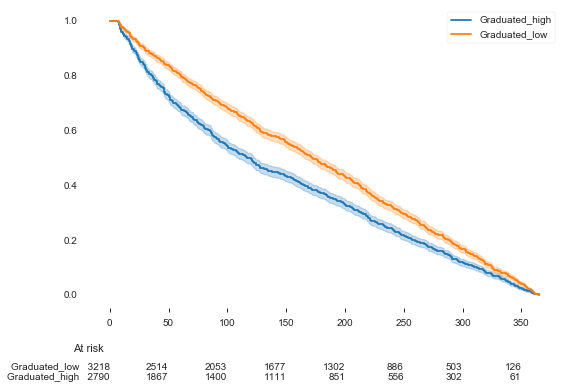

In [82]:
kmg('Graduated')

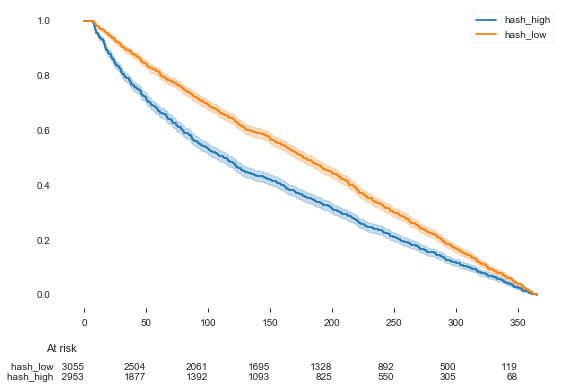

In [84]:
kmg('hash')

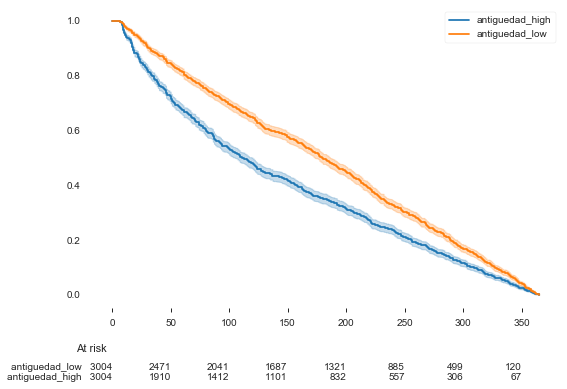

In [85]:
kmg('antiguedad')

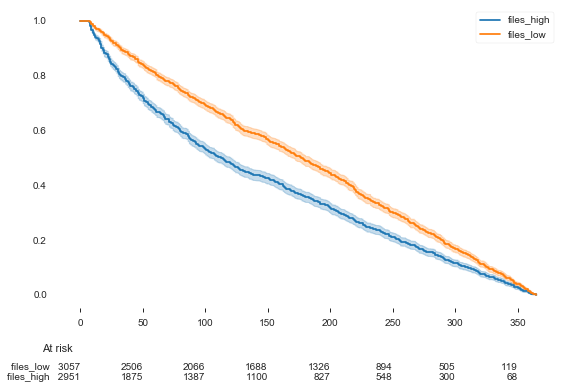

In [86]:
kmg('files')

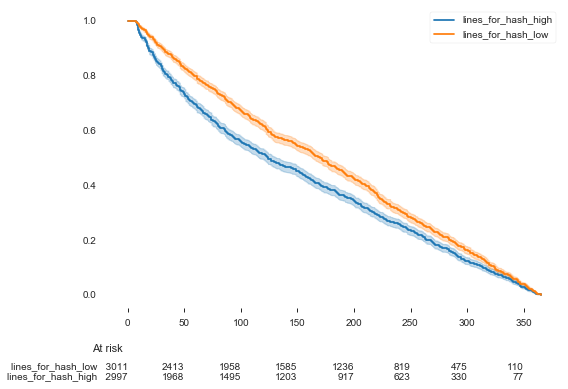

In [87]:
kmg('lines_for_hash')

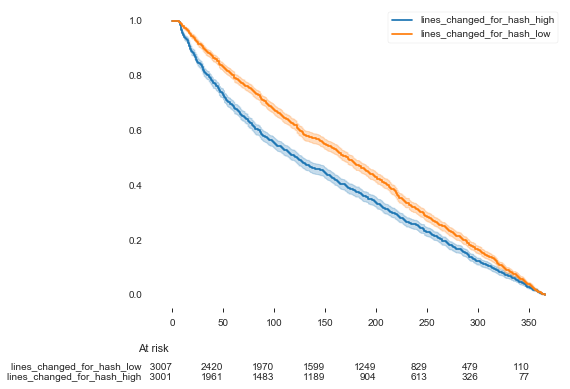

In [88]:
kmg('lines_changed_for_hash')

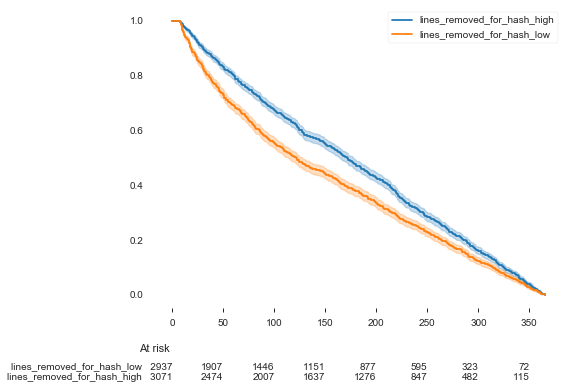

In [522]:
kmg('lines_removed_for_hash')

In [132]:
def kmg2 (var):   
    df_suvirval3['ant']=pd.cut(df_suvirval3[var], 2, labels=["low", "high"],duplicates='drop')
    ix = df_suvirval3['ant'] == 'high'
    ax = plt.subplot(111)
    kmf_control = KaplanMeierFitter()
    ax = kmf_control.fit(df_suvirval3.loc[ix]['SurvivalTime'], df_suvirval3.loc[ix]['evento'], label=var+'_high').plot(ax=ax)
    kmf_exp = KaplanMeierFitter()
    ax = kmf_exp.fit(df_suvirval3.loc[~ix]['SurvivalTime'], df_suvirval3.loc[~ix]['evento'], label=var+'_low').plot(ax=ax)
    return add_at_risk_counts(kmf_exp, kmf_control, ax=ax)

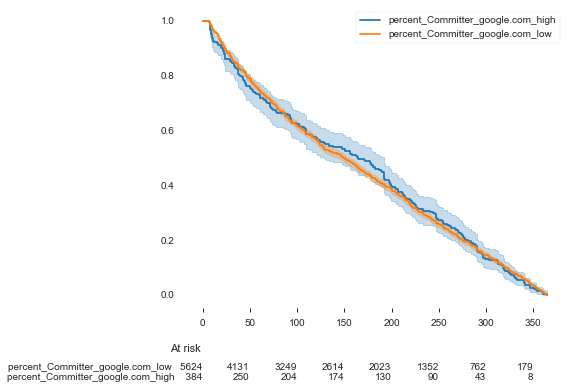

In [133]:
kmg2('percent_Committer_google.com')

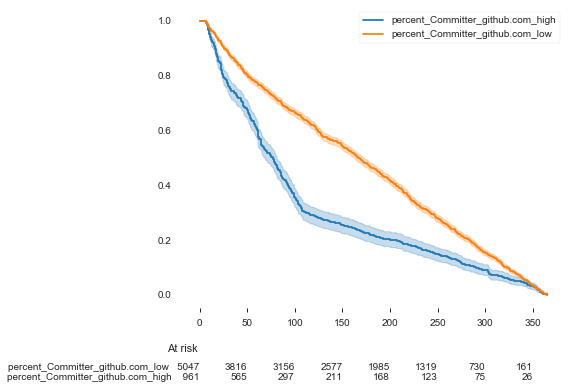

In [134]:
kmg2('percent_Committer_github.com')

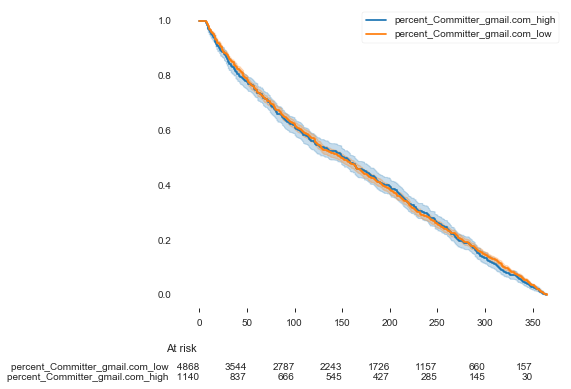

In [135]:
kmg2('percent_Committer_gmail.com')

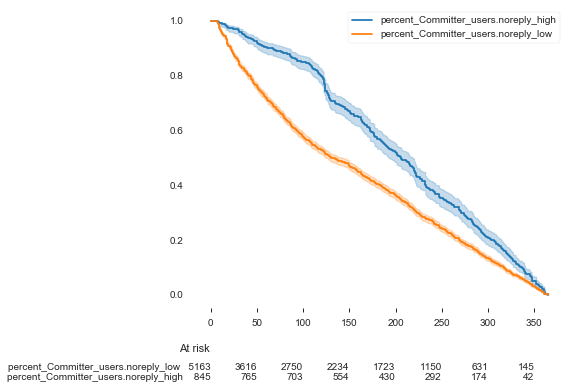

In [136]:
kmg2('percent_Committer_users.noreply')

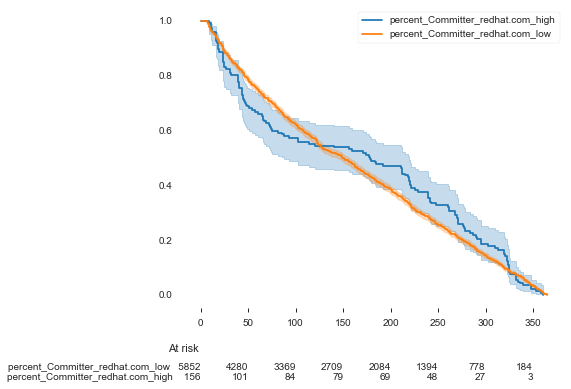

In [137]:
kmg2('percent_Committer_redhat.com')

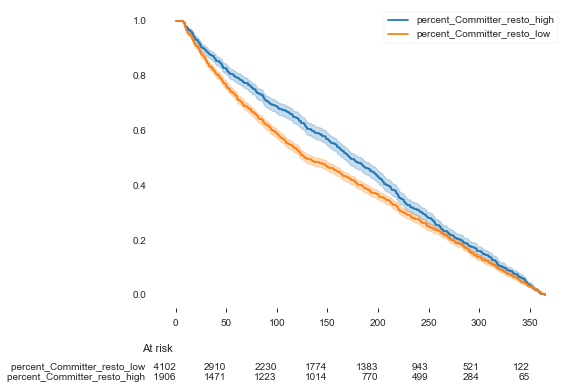

In [138]:
kmg2('percent_Committer_resto')

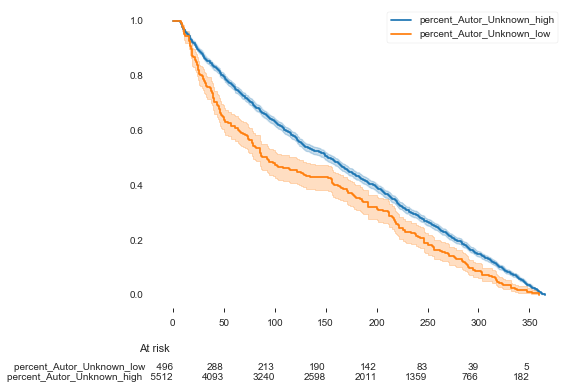

In [139]:
kmg2('percent_Autor_Unknown')

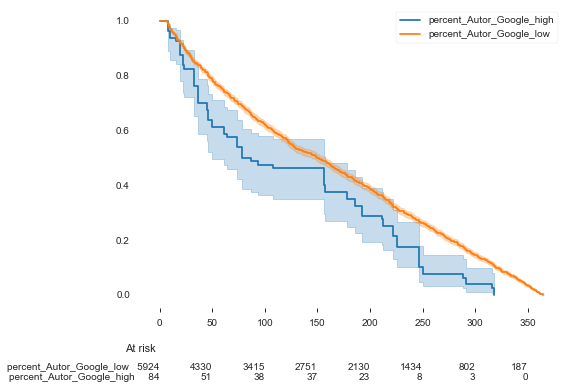

In [140]:
kmg2('percent_Autor_Google')

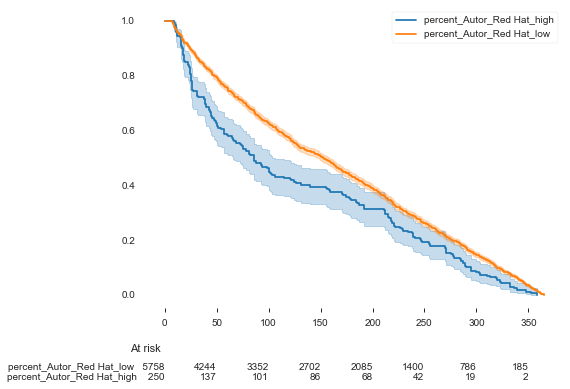

In [141]:
kmg2('percent_Autor_Red Hat')

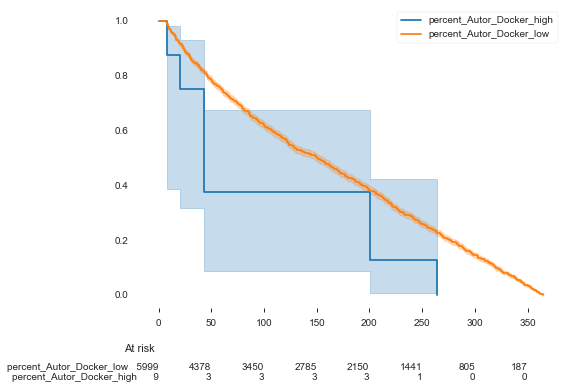

In [143]:
kmg2('percent_Autor_Docker')

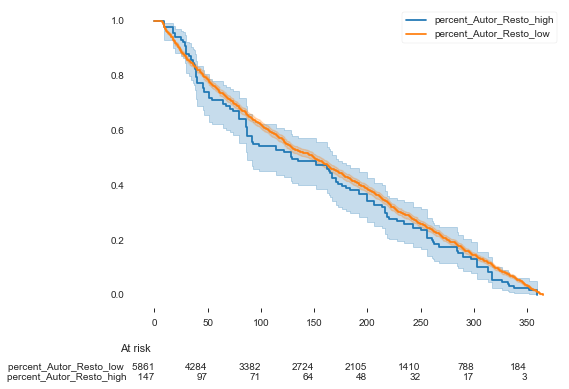

In [144]:
kmg2('percent_Autor_Resto')

### TO DO REGRESSION DE COX

In [67]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()   ## Instantiate the class to create a cph object

In [68]:
cph.fit(X_train, 'SurvivalTime', event_col='evento')   ## Fit the data to train the model
cph.print_summary()    ## HAve a look at the significance of the features